## [Booster Box] - Data Scientist Case Study
Author: Navid Yamini

Email: navid.yamini@studenti.polito.it

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import time
from functools import reduce
import datetime as dt 

In [2]:
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
# Set path for input data
file_path = "Input Data/"

#### Read Input Files

In [5]:
daily_operations = pd.read_csv (file_path +'daily_operations.csv')
daily_operations.head()

date  stock_availability_perc website_version
0  2019-01-01                    100.0             old
1  2019-01-02                     98.0             old
2  2019-01-03                     99.0             old
3  2019-01-04                     98.0             old
4  2019-01-05                     99.0             old

In [6]:
daily_spend_by_channel = pd.read_csv (file_path +'daily_spend_by_channel.csv')
daily_spend_by_channel.head()

date  gads_spend   fb_spend  criteo_spend  bing_spend  tiktok_spend  \
0  2019-01-01    9.363503  65.123298      8.167795    5.660184           0.0   
1  2019-01-02   95.071431   2.664826      0.454035    8.780335           0.0   
2  2019-01-03   73.199394  65.784530      0.927353    5.578737           0.0   
3  2019-01-04   59.865848  99.941373      9.019402    9.597910           0.0   
4  2019-01-05    3.900466   1.205301      8.066935    0.121737           0.0   

   amazon_spend  
0     45.686375  
1     41.649707  
2      3.719634  
3     39.464533  
4      0.390170

In [7]:
daily_transactions = pd.read_csv (file_path +'daily_transactions.csv')
daily_transactions.head()

date  transaction_id
0  2019-01-01          100000
1  2019-01-01          100001
2  2019-01-01          100002
3  2019-01-01          100003
4  2019-01-01          100004

#### Check the Description and Size

In [8]:
daily_operations.describe().T

count      mean       std   min   25%   50%   75%  \
stock_availability_perc  1461.0  98.98768  0.689341  98.0  99.0  99.0  99.0   

                           max  
stock_availability_perc  100.0

In [9]:
daily_spend_by_channel.describe().T

count       mean        std       min       25%        50%  \
gads_spend    1461.0  43.954863  35.068453  0.115801  5.901262  50.588868   
fb_spend      1461.0  43.875949  34.480615  0.000291  6.413252  49.781251   
criteo_spend  1461.0   4.323193   3.431808  0.000077  0.620959   5.001128   
bing_spend    1461.0   4.344338   3.486150  0.000568  0.619079   4.852305   
tiktok_spend  1461.0   5.484347  12.779746  0.000000  0.000000   0.000000   
amazon_spend  1461.0  21.026330  16.972056  0.003037  2.950099  23.432582   

                    75%        max  
gads_spend    75.337819  99.971767  
fb_spend      75.117805  99.941373  
criteo_spend   7.330001   9.995577  
bing_spend     7.486087   9.993503  
tiktok_spend   0.000000  49.584307  
amazon_spend  35.496654  49.945235

In [10]:
daily_transactions.shape

(363047, 2)

#### Check for Duplicates 

In [11]:
daily_operations.duplicated()
dates = daily_operations["date"]
daily_operations[dates.isin(dates[dates.duplicated()])]

Empty DataFrame
Columns: [date, stock_availability_perc, website_version]
Index: []

In [12]:
daily_spend_by_channel.duplicated()
dates = daily_spend_by_channel["date"]
daily_spend_by_channel[dates.isin(dates[dates.duplicated()])]

Empty DataFrame
Columns: [date, gads_spend, fb_spend, criteo_spend, bing_spend, tiktok_spend, amazon_spend]
Index: []

In [13]:
daily_transactions.duplicated()
transaction_id = daily_transactions["transaction_id"]
daily_transactions[transaction_id.isin(transaction_id[transaction_id.duplicated()])]

Empty DataFrame
Columns: [date, transaction_id]
Index: []

#### Check for Null Values

In [14]:
nan_count = daily_spend_by_channel.isna().sum()
nan_count

date            0
gads_spend      0
fb_spend        0
criteo_spend    0
bing_spend      0
tiktok_spend    0
amazon_spend    0
dtype: int64

In [15]:
nan_count = daily_transactions.isna().sum()
nan_count

date              0
transaction_id    0
dtype: int64

In [16]:
nan_count = daily_operations.isna().sum()
nan_count

date                       0
stock_availability_perc    0
website_version            0
dtype: int64

####  Some Data Manipulation

In [17]:
# Calculate the total money which has been spent on each day
daily_spend_by_channel["total"] = daily_spend_by_channel.sum(axis = 1)
daily_spend_by_channel.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


date  gads_spend   fb_spend  criteo_spend  bing_spend  tiktok_spend  \
0  2019-01-01    9.363503  65.123298      8.167795    5.660184           0.0   
1  2019-01-02   95.071431   2.664826      0.454035    8.780335           0.0   
2  2019-01-03   73.199394  65.784530      0.927353    5.578737           0.0   
3  2019-01-04   59.865848  99.941373      9.019402    9.597910           0.0   
4  2019-01-05    3.900466   1.205301      8.066935    0.121737           0.0   

   amazon_spend       total  
0     45.686375  134.001154  
1     41.649707  148.620333  
2      3.719634  149.209648  
3     39.464533  217.889066  
4      0.390170   13.684609

#### Plot Daily Spend by Channel

In [18]:
daily_spend_by_channel_box_plot = daily_spend_by_channel.drop(['date',],axis=1)

fig = go.Figure()

for col in daily_spend_by_channel_box_plot:
  fig.add_trace(go.Box(y=daily_spend_by_channel_box_plot[col].values, name=daily_spend_by_channel_box_plot[col].name))
  
fig.show()

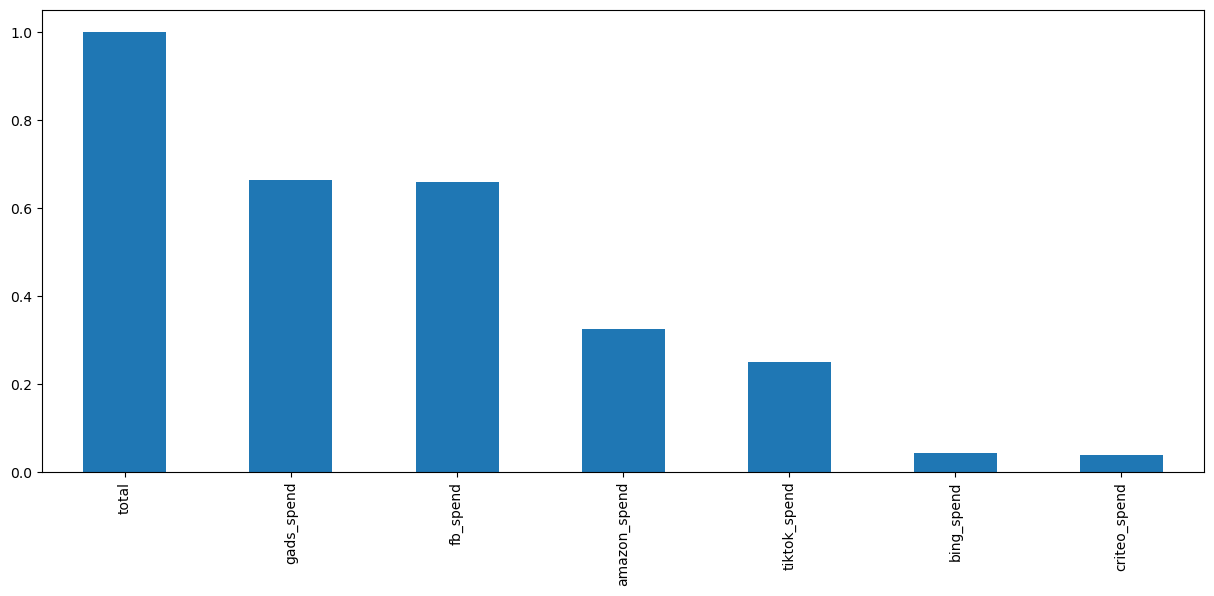

In [19]:
plt.figure(figsize=(15,6))
bars = daily_spend_by_channel.corr()['total'].sort_values(ascending=False).plot(kind='bar')

#### More Data Manipulation 

In [20]:
# Count the transaction for each day
daily_transactions_count = daily_transactions.drop(['transaction_id'], axis=1)
value = daily_transactions_count.groupby("date").size().values
daily_transactions_count = daily_transactions.drop_duplicates(subset="date").assign(transaction_count=value)
daily_transactions_count =pd.DataFrame(daily_transactions_count.drop(['transaction_id'], axis=1)).reset_index(drop=True)
daily_transactions_count

date  transaction_count
0     2019-01-01                245
1     2019-01-02                260
2     2019-01-03                259
3     2019-01-04                325
4     2019-01-05                121
...          ...                ...
1456  2022-12-27                406
1457  2022-12-28                376
1458  2022-12-29                269
1459  2022-12-30                329
1460  2022-12-31                333

[1461 rows x 2 columns]

In [21]:
# Merge three tables base on date 
data_frames = [daily_transactions_count, daily_spend_by_channel,daily_operations]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'], how='outer'), data_frames)
df_merged

date  transaction_count  gads_spend   fb_spend  criteo_spend  \
0     2019-01-01                245    9.363503  65.123298      8.167795   
1     2019-01-02                260   95.071431   2.664826      0.454035   
2     2019-01-03                259   73.199394  65.784530      0.927353   
3     2019-01-04                325   59.865848  99.941373      9.019402   
4     2019-01-05                121    3.900466   1.205301      8.066935   
...          ...                ...         ...        ...           ...   
1456  2022-12-27                406   68.952675  84.842538      0.363317   
1457  2022-12-28                376   67.651339  42.262920      5.056967   
1458  2022-12-29                269    5.391879   7.573273      0.155104   
1459  2022-12-30                329   65.888547   8.132378      0.177889   
1460  2022-12-31                333    9.846610  71.262133      5.738658   

      bing_spend  tiktok_spend  amazon_spend       total  \
0       5.660184      0.000000     45.686375  134.001154   
1       8.780335      0.000000     41.649707  148.620333   
2       5.578737      0.000000      3.719634  149.209648   
3       9.597910      0.000000     39.464533  217.889066   
4       0.121737      0.000000      0.390170   13.684609   
...          ...           ...           ...         ...   
1456    6.300187      1.612955     33.568400  195.640072   
1457    4.173829     21.515821     26.157907  166.818784   
1458    0.360780      3.433813     44.931946   61.846794   
1459    0.233899     44.387576      2.054909  120.875198   
1460    0.041679      0.507321     40.205462  127.601865   

      stock_availability_perc website_version  
0                       100.0             old  
1                        98.0             old  
2                        99.0             old  
3                        98.0             old  
4                        99.0             old  
...                       ...             ...  
1456                    100.0             new  
1457                     99.0             new  
1458                     98.0             new  
1459                     99.0             new  
1460                     99.0             new  

[1461 rows x 11 columns]

In [22]:
#Replace old and new string with = and 1 in website_version and drop it
df_merged.loc[df_merged['website_version'] == 'old', 'website_boolean_version'] = 0
df_merged.loc[df_merged['website_version'] == 'new', 'website_boolean_version'] = 1
df_merged = df_merged.drop(['website_version'],axis=1)

In [23]:
# check the types
df_merged.dtypes 

date                        object
transaction_count            int64
gads_spend                 float64
fb_spend                   float64
criteo_spend               float64
bing_spend                 float64
tiktok_spend               float64
amazon_spend               float64
total                      float64
stock_availability_perc    float64
website_boolean_version    float64
dtype: object

In [24]:
# Change transaction count data type
df_merged['transaction_count'] = df_merged['transaction_count'].astype(float)

In [25]:
# Find the first date that the new website is online
first_new_website = df_merged.drop_duplicates(['website_boolean_version','date'])
first_new_website = first_new_website[first_new_website.groupby('website_boolean_version').cumcount().eq(0)]
first_new_website

date  transaction_count  gads_spend   fb_spend  criteo_spend  \
0     2019-01-01              245.0    9.363503  65.123298      8.167795   
1258  2022-06-12              250.0    1.605223   0.589874      4.027037   

      bing_spend  tiktok_spend  amazon_spend       total  \
0       5.660184      0.000000     45.686375  134.001154   
1258    8.194957     47.951209     44.092740  106.461040   

      stock_availability_perc  website_boolean_version  
0                       100.0                      0.0  
1258                     99.0                      1.0

In [26]:
# Find the first day that Tiktak is used
first_tiktok_spend = df_merged.drop_duplicates(['tiktok_spend','date'])
first_tiktok_spend = first_tiktok_spend[first_tiktok_spend.groupby('tiktok_spend').cumcount().eq(0)]
first_tiktok_spend[:2]

date  transaction_count  gads_spend   fb_spend  criteo_spend  \
0     2019-01-01              245.0    9.363503  65.123298      8.167795   
1097  2022-01-02              272.0    4.660957   1.921552      0.574984   

      bing_spend  tiktok_spend  amazon_spend       total  \
0       5.660184      0.000000     45.686375  134.001154   
1097    8.116270     43.357608     29.166645   87.798016   

      stock_availability_perc  website_boolean_version  
0                       100.0                      0.0  
1097                    100.0                      0.0

In [27]:
# Save first dates
new_website_date = first_new_website.iloc[1]['date']
tiktok_first_date = first_tiktok_spend.iloc[1]['date']

In [28]:
new_website_date

'2022-06-12'

In [29]:
tiktok_first_date

'2022-01-02'

#### Studying the Correlation and using Scatter Plot

In [30]:
df_merged.corr()

transaction_count  gads_spend  fb_spend  \
transaction_count                 1.000000    0.490887  0.479626   
gads_spend                        0.490887    1.000000  0.032022   
fb_spend                          0.479626    0.032022  1.000000   
criteo_spend                     -0.001356   -0.034337  0.005365   
bing_spend                        0.013221   -0.016588  0.005108   
tiktok_spend                      0.341665    0.045317 -0.014642   
amazon_spend                      0.234774   -0.006057  0.043955   
total                             0.766911    0.663704  0.658707   
stock_availability_perc           0.005336    0.011387  0.015662   
website_boolean_version           0.256901   -0.000126  0.000818   

                         criteo_spend  bing_spend  tiktok_spend  amazon_spend  \
transaction_count           -0.001356    0.013221      0.341665      0.234774   
gads_spend                  -0.034337   -0.016588      0.045317     -0.006057   
fb_spend                     0.005365    0.005108     -0.014642      0.043955   
criteo_spend                 1.000000   -0.016534      0.024304     -0.032312   
bing_spend                  -0.016534    1.000000      0.007363     -0.045479   
tiktok_spend                 0.024304    0.007363      1.000000     -0.015838   
amazon_spend                -0.032312   -0.045479     -0.015838      1.000000   
total                        0.038527    0.042691      0.249378      0.323968   
stock_availability_perc      0.025016    0.003336     -0.039086     -0.002875   
website_boolean_version     -0.002620    0.015390      0.530527     -0.015837   

                            total  stock_availability_perc  \
transaction_count        0.766911                 0.005336   
gads_spend               0.663704                 0.011387   
fb_spend                 0.658707                 0.015662   
criteo_spend             0.038527                 0.025016   
bing_spend               0.042691                 0.003336   
tiktok_spend             0.249378                -0.039086   
amazon_spend             0.323968                -0.002875   
total                    1.000000                 0.008890   
stock_availability_perc  0.008890                 1.000000   
website_boolean_version  0.119730                -0.012919   

                         website_boolean_version  
transaction_count                       0.256901  
gads_spend                             -0.000126  
fb_spend                                0.000818  
criteo_spend                           -0.002620  
bing_spend                              0.015390  
tiktok_spend                            0.530527  
amazon_spend                           -0.015837  
total                                   0.119730  
stock_availability_perc                -0.012919  
website_boolean_version                 1.000000

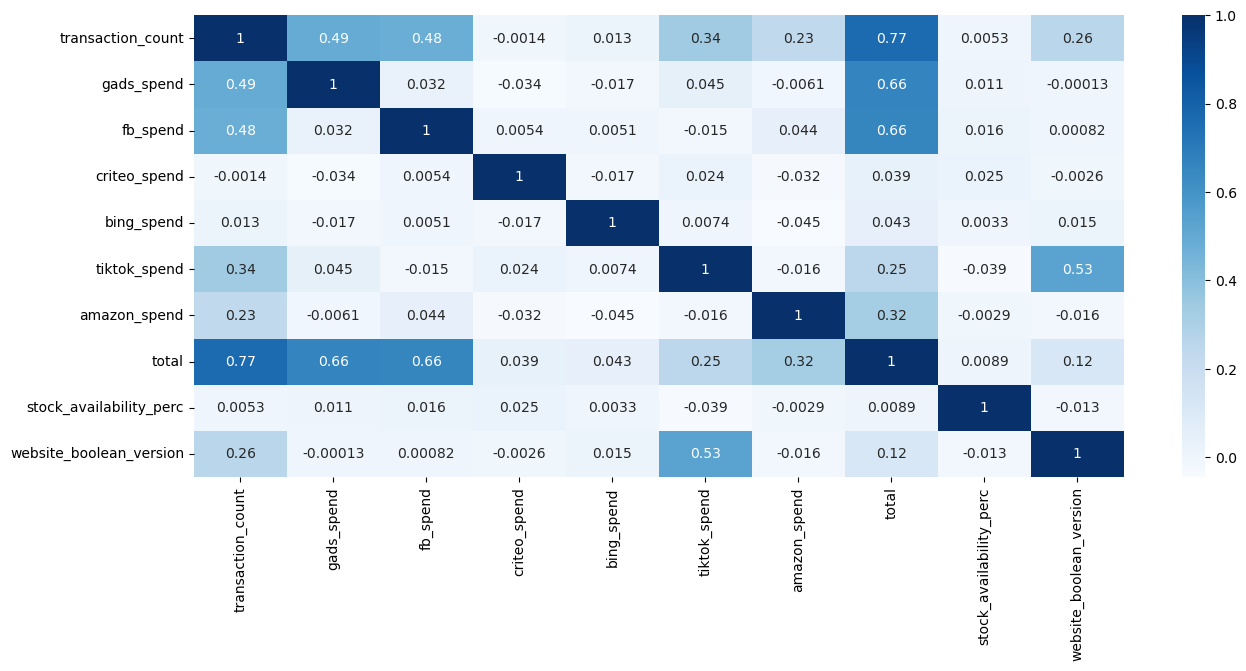

In [31]:
plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df_merged.corr(), annot=True, cmap="Blues")

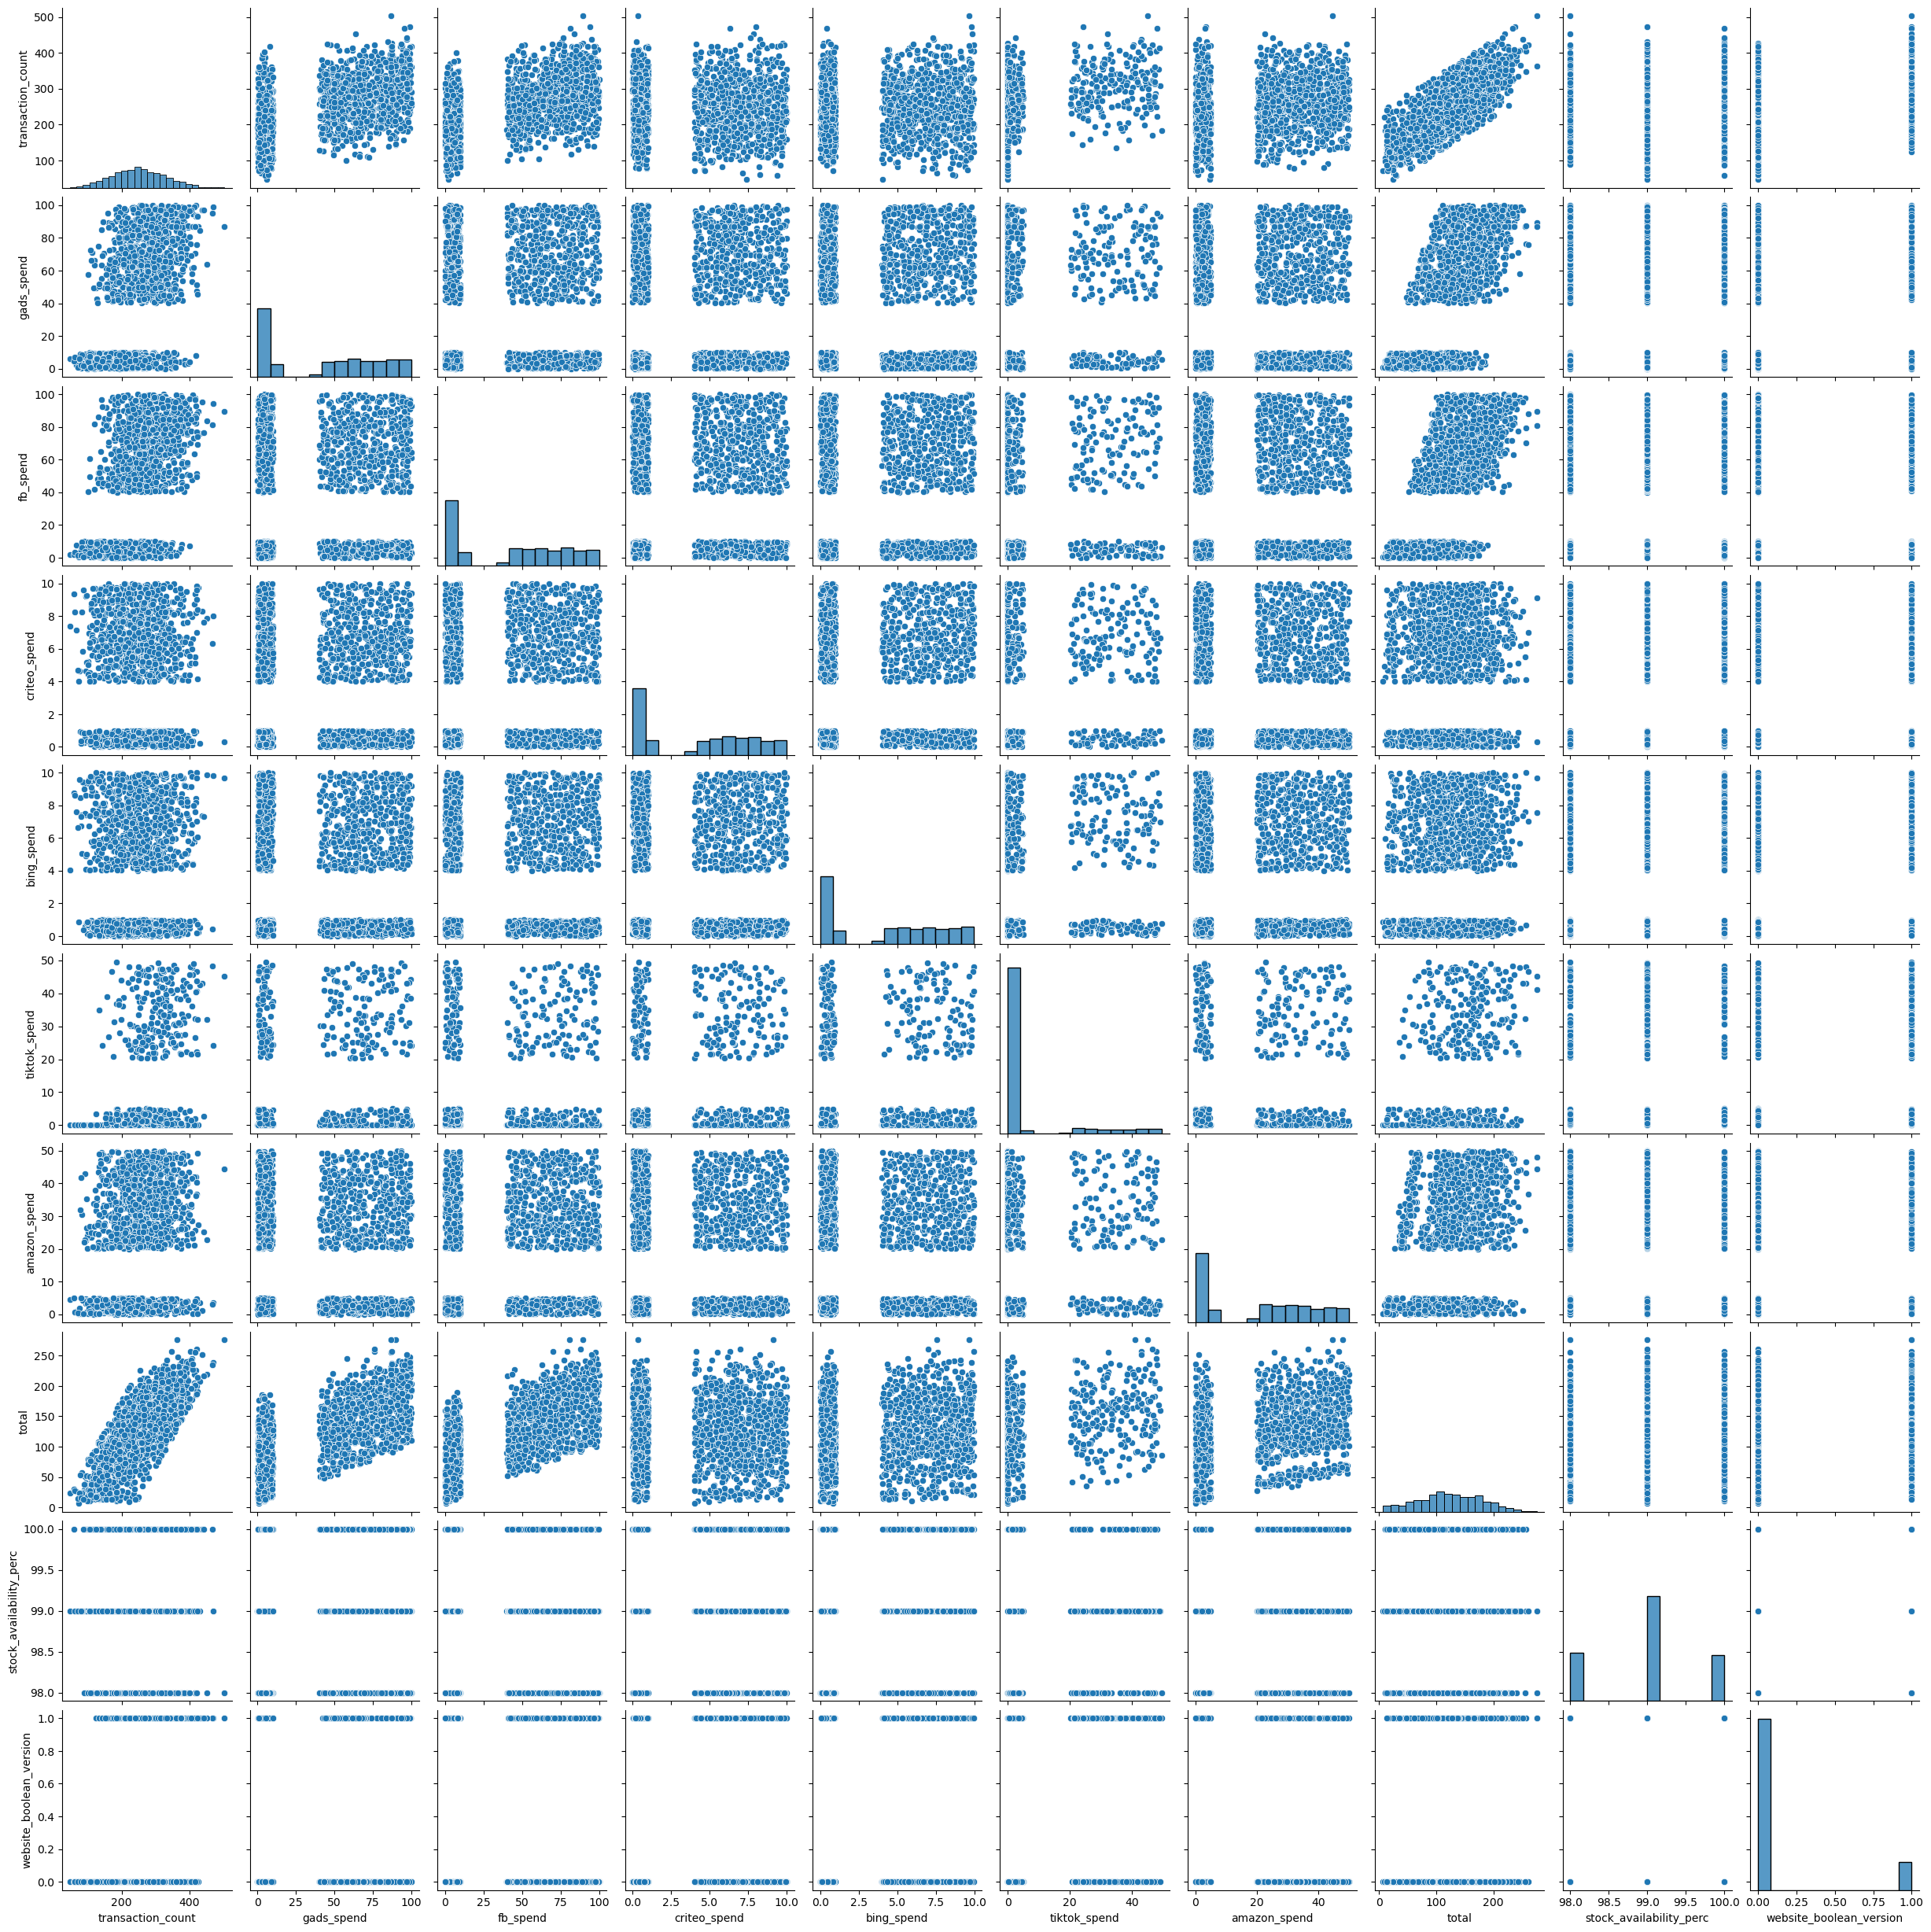

In [32]:
sns.pairplot(df_merged)

#### Create 4 different data frame, aggregated based on week and month

In [33]:
# create weeakly aggregate 
df_merged['date'] = pd.to_datetime(df_merged['date'])
year_week = df_merged.assign(year_week= df_merged['date'].dt.strftime('%Y_%U')).sort_values('year_week')
year_week_sum = year_week.groupby(by = ['year_week']).sum()
year_week_sum= year_week_sum.reset_index()
year_week_mean = year_week.groupby(by = ['year_week']).mean()
year_week_mean= year_week_mean.reset_index()

In [34]:
year_week_sum.head()

year_week  transaction_count  gads_spend    fb_spend  criteo_spend  \
0   2019_00             1210.0  241.400642  234.719327     26.635519   
1   2019_01             1748.0  320.393924  522.120211     36.531685   
2   2019_02             1478.0  200.959680  395.702004     31.447145   
3   2019_03             1106.0  212.540621  166.562026     31.974973   
4   2019_04             1068.0  183.461884  146.911572     46.469981   

   bing_spend  tiktok_spend  amazon_spend        total  \
0   29.738903           0.0    130.910418   663.404810   
1   22.260471           0.0    133.785020  1035.091310   
2   15.592059           0.0    191.268434   834.969322   
3   29.049710           0.0     76.591460   516.718790   
4   27.876549           0.0    127.423266   532.143251   

   stock_availability_perc  website_boolean_version  
0                    494.0                      0.0  
1                    693.0                      0.0  
2                    694.0                      0.0  
3                    692.0                      0.0  
4                    690.0                      0.0

In [35]:
# create monthly aggregate
year_month = df_merged.assign(year_month= df_merged['date'].dt.strftime('%Y_%m')).sort_values('year_month')
year_month_mean = year_month.groupby(by = ['year_month']).mean()
year_month_mean= year_month_mean.reset_index()
year_month_sum = year_month.groupby(by = ['year_month']).sum()
year_month_sum= year_month_sum.reset_index()

In [36]:
year_month_mean.tail()

year_month  transaction_count  gads_spend   fb_spend  criteo_spend  \
43    2022_08         240.258065   46.292167  48.682786      3.953171   
44    2022_09         277.100000   50.280866  47.421152      4.566756   
45    2022_10         322.032258   40.349302  39.398521      4.754862   
46    2022_11         370.533333   43.906951  47.536663      4.885956   
47    2022_12         355.677419   50.081217  39.888113      3.333479   

    bing_spend  tiktok_spend  amazon_spend       total  \
43    3.906039     24.675521     20.382233  147.891916   
44    5.124229     21.253655     18.325860  146.972519   
45    4.574514     25.728234     17.072036  131.877470   
46    4.622304     18.405533     22.307382  141.664789   
47    4.324266     19.256347     16.970904  133.854327   

    stock_availability_perc  website_boolean_version  
43                98.967742                      1.0  
44                98.766667                      1.0  
45                99.032258                      1.0  
46                98.900000                      1.0  
47                98.870968                      1.0

In [37]:
# plot the daily values
fig = px.line(df_merged, x='date', y=df_merged.columns)
fig.add_vline(x=new_website_date, line_width=1, line_dash="dash", line_color="green")
fig.add_vline(x=tiktok_first_date, line_width=1, line_dash="dash", line_color="red")
fig.show()

In [38]:
# find the first month with new website and first spent on tiktok
first_new_website = year_month_mean.drop_duplicates(['website_boolean_version','year_month'])
first_new_website = first_new_website[first_new_website.groupby('website_boolean_version').cumcount().eq(0)]
first_tiktok_spend = year_month_mean.drop_duplicates(['tiktok_spend','year_month'])
first_tiktok_spend = first_tiktok_spend[first_tiktok_spend.groupby('tiktok_spend').cumcount().eq(0)]
new_website_date = first_new_website.iloc[1]['year_month']
tiktok_first_date = first_tiktok_spend.iloc[1]['year_month']

In [39]:
# plot monthly values, aggregate by mean
fig = px.line(year_month_mean, x='year_month', y=year_month_mean.columns)
fig.add_vline(x=new_website_date, line_width=1, line_dash="dash", line_color="green")
fig.add_vline(x=tiktok_first_date, line_width=1, line_dash="dash", line_color="red")
fig.show()

In [40]:
# plot monthly values, aggregate by sum
fig = px.line(year_month_sum, x='year_month', y=year_month_sum.columns)
fig.add_vline(x=new_website_date, line_width=1, line_dash="dash", line_color="green")
fig.add_vline(x=tiktok_first_date, line_width=1, line_dash="dash", line_color="red")
fig.show()

In [41]:
# find the first week with new website and first spent on tiktok
first_new_website = year_week_mean.drop_duplicates(['website_boolean_version','year_week'])
first_new_website = first_new_website[first_new_website.groupby('website_boolean_version').cumcount().eq(0)]
first_tiktok_spend = year_week_mean.drop_duplicates(['tiktok_spend','year_week'])
first_tiktok_spend = first_tiktok_spend[first_tiktok_spend.groupby('tiktok_spend').cumcount().eq(0)]
new_website_date = first_new_website.iloc[1]['year_week']
tiktok_first_date = first_tiktok_spend.iloc[1]['year_week']

In [42]:
# plot weekly values, aggregate by mean
fig = px.line(year_week_mean, x='year_week', y=year_week_sum.columns)
fig.add_vline(x=new_website_date, line_width=1, line_dash="dash", line_color="green")
fig.add_vline(x=tiktok_first_date, line_width=1, line_dash="dash", line_color="red")
fig.show()

In [43]:
# plot weekly values, aggregate by sum
fig = px.line(year_week_sum, x='year_week', y=year_week_sum.columns)
fig.add_vline(x=new_website_date, line_width=1, line_dash="dash", line_color="green")
fig.add_vline(x=tiktok_first_date, line_width=1, line_dash="dash", line_color="red")
fig.show()

## Create the Model for Daily data

In [44]:
# Dictionary for all the needed algorithms
regressors = {
    "XGBRegressor": XGBRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "LinearSVR": LinearSVR(),
    "KernelRidge": KernelRidge(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
}

In [45]:
# Create the Feature matrix and Target Varibale
X = df_merged[['gads_spend', 'fb_spend', 'criteo_spend', 'bing_spend','tiktok_spend','amazon_spend','stock_availability_perc','website_boolean_version']]
y = df_merged['transaction_count']

In [46]:
# Run the OLS for att selection
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     300.9
Date:                Mon, 27 Feb 2023   Prob (F-statistic):          9.95e-302
Time:                        01:43:36   Log-Likelihood:                -7688.2
No. Observations:                1461   AIC:                         1.539e+04
Df Residuals:                    1452   BIC:                         1.544e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### criteo_spend,bing_spend,stock_availability_perc are insignificant. 
Traditionally, a significance level of 0.05 (or 5%) is commonly used, meaning that if the p-value is less than or equal to 0.05, then the null hypothesis is rejected at the 5% level of significance.



In [47]:
# Drop the insignificant ones
X = df_merged[['gads_spend', 'fb_spend','tiktok_spend','amazon_spend','website_boolean_version']]
y = df_merged['transaction_count']

In [48]:
# Rerun the OLs 
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     480.7
Date:                Mon, 27 Feb 2023   Prob (F-statistic):          5.39e-305
Time:                        01:43:37   Log-Likelihood:                -7689.8
No. Observations:                1461   AIC:                         1.539e+04
Df Residuals:                    1455   BIC:                         1.542e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [49]:
# Create teat and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=0)

In [50]:
# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
# find the best model
df_regression_models_resutls = pd.DataFrame(columns=['model', 'run_time','rmse','rmse_cv'])

for key in regressors:
    print('Model', key, 'is running')
    start_time = time.time()
    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    scores = cross_val_score(model,
                            X_train,
                            y_train,
                            scoring='neg_mean_squared_error',
                            cv=10)
    
    row = {'model': key,
          'run_time': format(round((time.time() - start_time)/60,2)),
          'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
          'rmse_cv': round(np.mean(np.sqrt(-scores)))
          }
    df_regression_models_resutls = df_regression_models_resutls.append(row, ignore_index=True)
    
print('Done.')

Model XGBRegressor is running
Model RandomForestRegressor is running
Model DecisionTreeRegressor is running
Model GaussianProcessRegressor is running
Model SVR is running
Model NuSVR is running
Model LinearSVR is running
Model KernelRidge is running
Model LinearRegression is running
Model Ridge is running
Model Lars is running


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import 

Model TheilSenRegressor is running
Model HuberRegressor is running
Model PassiveAggressiveRegressor is running
Model ARDRegression is running
Model BayesianRidge is running
Model ElasticNet is running
Model OrthogonalMatchingPursuit is running
Model GradientBoostingRegressor is running


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skl

Done.


In [52]:
df_regression_models_resutls

model run_time rmse rmse_cv
0                 XGBRegressor     0.04   55      52
1        RandomForestRegressor     0.06   51      50
2        DecisionTreeRegressor      0.0   66      68
3     GaussianProcessRegressor     0.02  399     948
4                          SVR     0.01   57      56
5                        NuSVR     0.01   58      57
6                    LinearSVR      0.0   51      52
7                  KernelRidge     0.01  251     254
8             LinearRegression      0.0   47      47
9                        Ridge      0.0   47      47
10                        Lars      0.0   47      47
11           TheilSenRegressor     0.11   66      65
12              HuberRegressor      0.0   47      47
13  PassiveAggressiveRegressor      0.0   51      50
14               ARDRegression      0.0   47      47
15               BayesianRidge      0.0   47      47
16                  ElasticNet      0.0   52      51
17   OrthogonalMatchingPursuit      0.0   68      68
18   GradientBoostingRegressor     0.02   49      48

In [53]:
# LinearRegression has the ood result
regressor = LinearRegression()
model = regressor.fit(X_train, y_train)

In [54]:
print('Model score train: ', model.score(X_train, y_train))
print('Model score test: ', model.score(X_test, y_test))

Model score train:  0.6191031854242777
Model score test:  0.6286979173558918


In [55]:
# run the prediction
y_pred = model.predict(X_test)

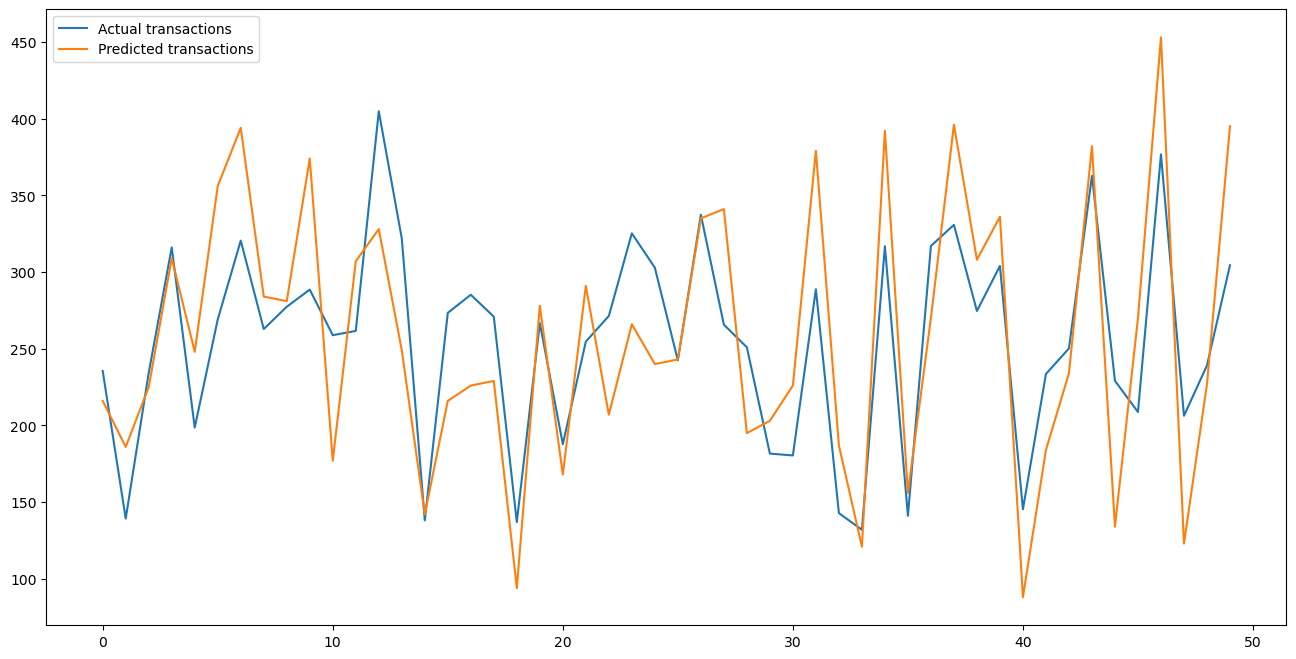

In [56]:
# plot the results to compare the 
test = pd.DataFrame({'Predicted transactions':y_pred, 'Actual transactions':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual transactions','Predicted transactions'])

## Create the Model for weekly data Avg

In [57]:
# Create the Feature matrix and Target Varibale
X = year_week_mean[['gads_spend', 'fb_spend', 'criteo_spend', 'bing_spend','tiktok_spend','amazon_spend','stock_availability_perc','website_boolean_version']]
y = year_week_mean['transaction_count']

In [58]:
# Run the OLS for att selection
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     15.24
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           1.89e-17
Time:                        01:43:57   Log-Likelihood:                -1109.7
No. Observations:                 212   AIC:                             2237.
Df Residuals:                     203   BIC:                             2268.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

#### criteo_spend, bing_spend, stock_availability_perc, website_boolean_version are insignificant. 
Traditionally, a significance level of 0.05 (or 5%) is commonly used, meaning that if the p-value is less than or equal to 0.05, then the null hypothesis is rejected at the 5% level of significance.



In [59]:
# Drop the insignificant ones
X = year_week_mean[['gads_spend', 'fb_spend','tiktok_spend','amazon_spend']]
y = year_week_mean['transaction_count']

In [60]:
# Rerun the OLs 
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     28.75
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           5.26e-19
Time:                        01:43:57   Log-Likelihood:                -1112.7
No. Observations:                 212   AIC:                             2235.
Df Residuals:                     207   BIC:                             2252.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          118.0166     17.731      6.656   

In [61]:
# Create teat and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=0)

In [62]:
# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
# find the best model
df_regression_models_resutls = pd.DataFrame(columns=['model', 'run_time','rmse','rmse_cv'])

for key in regressors:
    print('Model', key, 'is running')
    start_time = time.time()
    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    scores = cross_val_score(model,
                            X_train,
                            y_train,
                            scoring='neg_mean_squared_error',
                            cv=10)
    
    row = {'model': key,
          'run_time': format(round((time.time() - start_time)/60,2)),
          'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
          'rmse_cv': round(np.mean(np.sqrt(-scores)))
          }
    df_regression_models_resutls = df_regression_models_resutls.append(row, ignore_index=True)
    
print('Done.')

Model XGBRegressor is running
Model RandomForestRegressor is running
Model DecisionTreeRegressor is running
Model GaussianProcessRegressor is running
Model SVR is running
Model NuSVR is running
Model LinearSVR is running
Model KernelRidge is running
Model LinearRegression is running
Model Ridge is running
Model Lars is running
Model TheilSenRegressor is running


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import 

Model HuberRegressor is running
Model PassiveAggressiveRegressor is running
Model ARDRegression is running
Model BayesianRidge is running
Model ElasticNet is running
Model OrthogonalMatchingPursuit is running


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skl

Model GradientBoostingRegressor is running
Done.


In [64]:
df_regression_models_resutls

model run_time  rmse rmse_cv
0                 XGBRegressor     0.02    53      53
1        RandomForestRegressor     0.03    53      49
2        DecisionTreeRegressor      0.0    64      58
3     GaussianProcessRegressor      0.0  2178    1318
4                          SVR      0.0    56      54
5                        NuSVR      0.0    56      55
6                    LinearSVR      0.0   115     134
7                  KernelRidge      0.0   253     264
8             LinearRegression      0.0    51      46
9                        Ridge      0.0    51      46
10                        Lars      0.0    51      46
11           TheilSenRegressor     0.08    51      48
12              HuberRegressor      0.0    51      46
13  PassiveAggressiveRegressor      0.0    51      47
14               ARDRegression      0.0    51      47
15               BayesianRidge      0.0    51      46
16                  ElasticNet      0.0    52      47
17   OrthogonalMatchingPursuit      0.0    56      50
18   GradientBoostingRegressor     0.01    54      49

In [65]:
# LinearRegression has the ood result
regressor = LinearRegression()
model = regressor.fit(X_train, y_train)

In [66]:
print('Model score train: ', model.score(X_train, y_train))
print('Model score test: ', model.score(X_test, y_test))

Model score train:  0.40129431493614887
Model score test:  0.23280423104720627


In [67]:
# run the prediction
y_pred = model.predict(X_test)

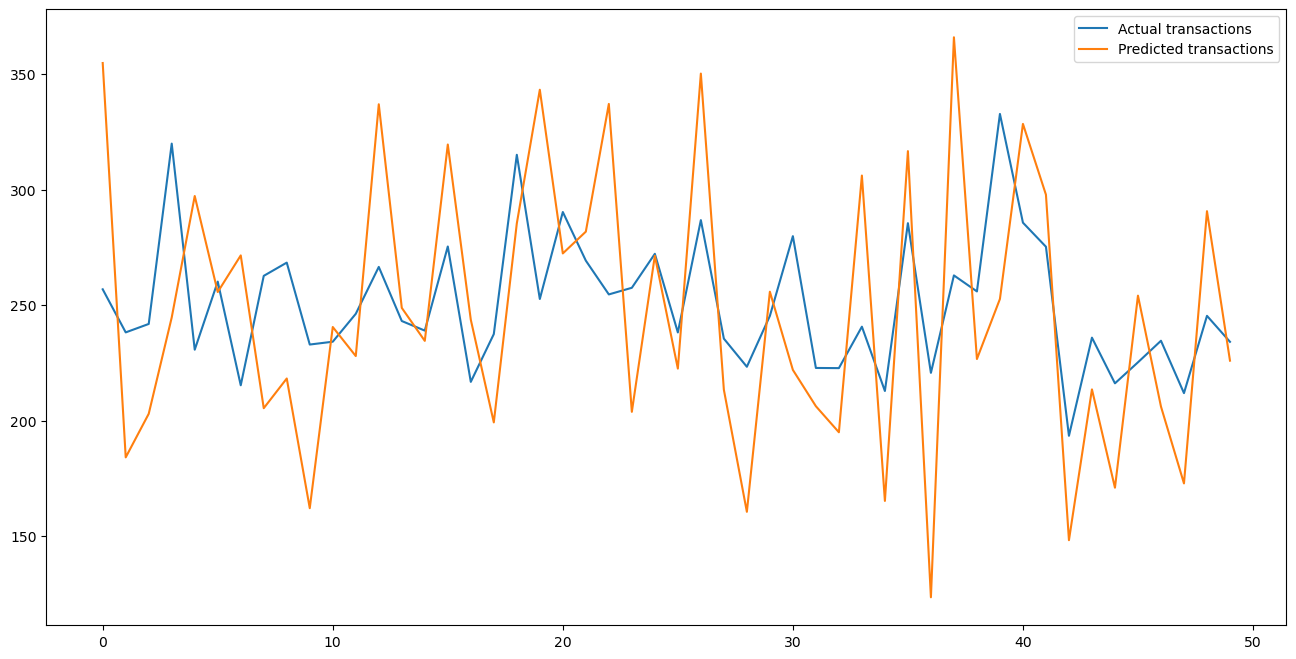

In [68]:
# plot the results to compare the 
test = pd.DataFrame({'Predicted transactions':y_pred, 'Actual transactions':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual transactions','Predicted transactions'])

## Create the Model for weekly data Sum

In [69]:
# Create the Feature matrix and Target Varibale
X = year_week_mean[['gads_spend', 'fb_spend', 'criteo_spend', 'bing_spend','tiktok_spend','amazon_spend','stock_availability_perc','website_boolean_version']]
y = year_week_mean['transaction_count']

In [70]:
# Run the OLS for att selection
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     15.24
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           1.89e-17
Time:                        01:44:08   Log-Likelihood:                -1109.7
No. Observations:                 212   AIC:                             2237.
Df Residuals:                     203   BIC:                             2268.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

#### criteo_spend, bing_spend, amazon_spend, website_boolean_version, stock_availability_perc are insignificant. 
Traditionally, a significance level of 0.05 (or 5%) is commonly used, meaning that if the p-value is less than or equal to 0.05, then the null hypothesis is rejected at the 5% level of significance.



In [71]:
# Drop the insignificant ones
X = year_week_sum[['gads_spend', 'fb_spend','tiktok_spend','stock_availability_perc']]
y = year_week_sum['transaction_count']

In [72]:
# Rerun the OLs 
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     38.53
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           4.36e-24
Time:                        01:44:08   Log-Likelihood:                -1524.2
No. Observations:                 212   AIC:                             3058.
Df Residuals:                     207   BIC:                             3075.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [73]:
# Create teat and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=0)

In [74]:
# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
# find the best model
df_regression_models_resutls = pd.DataFrame(columns=['model', 'run_time','rmse','rmse_cv'])

for key in regressors:
    print('Model', key, 'is running')
    start_time = time.time()
    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    scores = cross_val_score(model,
                            X_train,
                            y_train,
                            scoring='neg_mean_squared_error',
                            cv=10)
    
    row = {'model': key,
          'run_time': format(round((time.time() - start_time)/60,2)),
          'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
          'rmse_cv': round(np.mean(np.sqrt(-scores)))
          }
    df_regression_models_resutls = df_regression_models_resutls.append(row, ignore_index=True)
    
print('Done.')

Model XGBRegressor is running
Model RandomForestRegressor is running
Model DecisionTreeRegressor is running
Model GaussianProcessRegressor is running
Model SVR is running
Model NuSVR is running
Model LinearSVR is running
Model KernelRidge is running
Model LinearRegression is running
Model Ridge is running
Model Lars is running


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import 

Model TheilSenRegressor is running
Model HuberRegressor is running
Model PassiveAggressiveRegressor is running
Model ARDRegression is running
Model BayesianRidge is running
Model ElasticNet is running
Model OrthogonalMatchingPursuit is running
Model GradientBoostingRegressor is running


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from skl

Done.


In [76]:
df_regression_models_resutls

model run_time    rmse rmse_cv
0                 XGBRegressor     0.02     418     396
1        RandomForestRegressor     0.02     363     366
2        DecisionTreeRegressor      0.0     477     450
3     GaussianProcessRegressor      0.0  247414  232340
4                          SVR      0.0     427     420
5                        NuSVR      0.0     422     421
6                    LinearSVR      0.0    1578    1654
7                  KernelRidge      0.0    1756    1845
8             LinearRegression      0.0     345     322
9                        Ridge      0.0     345     321
10                        Lars      0.0     345     322
11           TheilSenRegressor     0.08     413     392
12              HuberRegressor      0.0     345     322
13  PassiveAggressiveRegressor      0.0     346     321
14               ARDRegression      0.0     345     326
15               BayesianRidge      0.0     345     322
16                  ElasticNet      0.0     351     331
17   OrthogonalMatchingPursuit      0.0     396     366
18   GradientBoostingRegressor     0.01     370     357

In [77]:
# LinearRegression has the ood result
regressor = PassiveAggressiveRegressor()
model = regressor.fit(X_train, y_train)

In [78]:
print('Model score train: ', model.score(X_train, y_train))
print('Model score test: ', model.score(X_test, y_test))

Model score train:  0.45636617597917606
Model score test:  0.3279638799048914


In [79]:
# run the prediction
y_pred = model.predict(X_test)

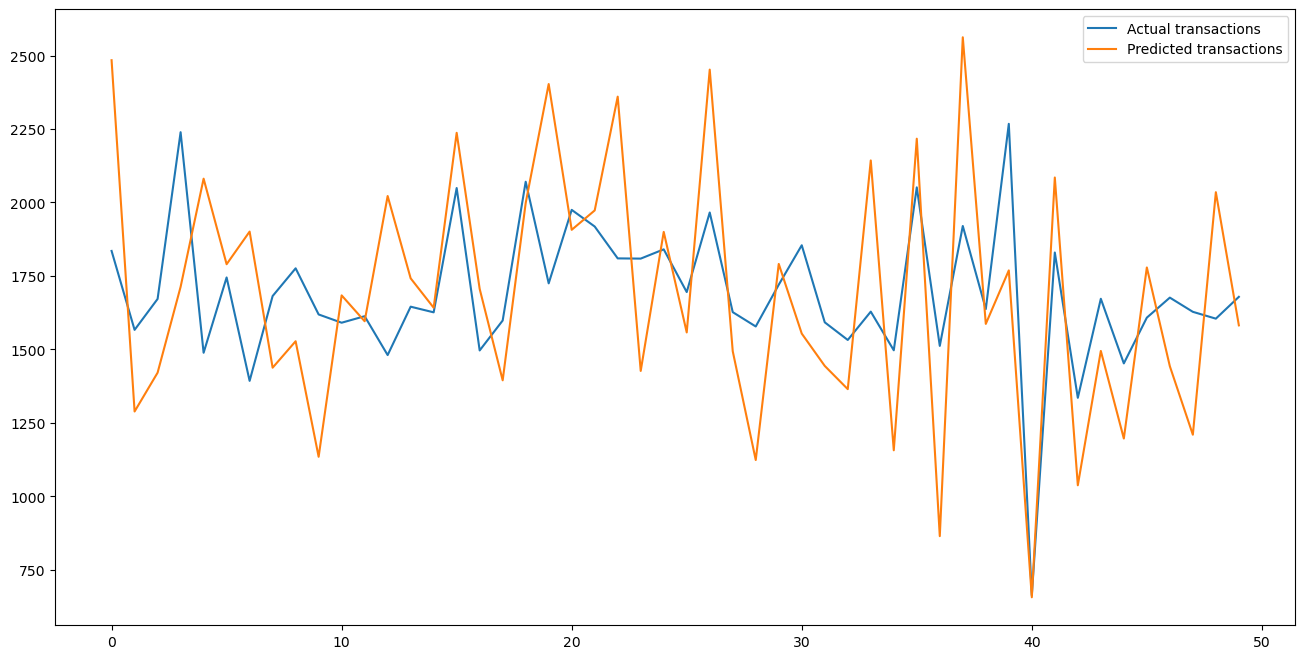

In [80]:
# plot the results to compare the 
test = pd.DataFrame({'Predicted transactions':y_pred, 'Actual transactions':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual transactions','Predicted transactions'])

## Create the Model for Monthly data Avg

In [81]:
# Create the Feature matrix and Target Varibale
X = year_month_mean[['gads_spend', 'fb_spend', 'criteo_spend', 'bing_spend','tiktok_spend','amazon_spend','stock_availability_perc','website_boolean_version']]
y = year_month_mean['transaction_count']

In [82]:
# Run the OLS for att selection
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     3.049
Date:                Mon, 27 Feb 2023   Prob (F-statistic):            0.00922
Time:                        01:44:18   Log-Likelihood:                -247.55
No. Observations:                  48   AIC:                             513.1
Df Residuals:                      39   BIC:                             529.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Only TilTok is significant and I don't continue to run this model. 
Traditionally, a significance level of 0.05 (or 5%) is commonly used, meaning that if the p-value is less than or equal to 0.05, then the null hypothesis is rejected at the 5% level of significance.



## Create the Model for Monthly data Sum

In [83]:
# Create the Feature matrix and Target Varibale
X = year_month_sum[['gads_spend', 'fb_spend', 'criteo_spend', 'bing_spend','tiktok_spend','amazon_spend','stock_availability_perc','website_boolean_version']]
y = year_month_sum['transaction_count']

In [84]:
# Run the OLS for att selection
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      transaction_count   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     3.129
Date:                Mon, 27 Feb 2023   Prob (F-statistic):            0.00788
Time:                        01:44:19   Log-Likelihood:                -411.77
No. Observations:                  48   AIC:                             841.5
Df Residuals:                      39   BIC:                             858.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Only TilTok is significant and I don't continue to run this model.
Traditionally, a significance level of 0.05 (or 5%) is commonly used, meaning that if the p-value is less than or equal to 0.05, then the null hypothesis is rejected at the 5% level of significance.
